In [1]:
import glob

import xarray as xr
from xclim import sdba
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import xesmf as xe
#rom dask.distributed import Client, LocalCluster

In [3]:
import dask.diagnostics
dask.diagnostics.ProgressBar().register()

In [4]:
#dask.config.set(temporary_directory='/g/data/wp00/dbi599')

In [5]:
#cluster = LocalCluster(n_workers=1)
#client = Client(cluster)

In [6]:
#client

In [7]:
hist_start = '1986-01-01'
hist_end = '2005-12-31'

In [8]:
rcp_start = '2021-01-01'
rcp_end = '2040-12-31'

## Obs data

In [9]:
obs_files = glob.glob('/g/data/zv2/agcd/v1/tmax/mean/r005/01day/agcd_v1_tmax_mean_r005_daily_*.nc')
obs_files.sort()

In [10]:
obs_files

['/g/data/zv2/agcd/v1/tmax/mean/r005/01day/agcd_v1_tmax_mean_r005_daily_1910.nc',
 '/g/data/zv2/agcd/v1/tmax/mean/r005/01day/agcd_v1_tmax_mean_r005_daily_1911.nc',
 '/g/data/zv2/agcd/v1/tmax/mean/r005/01day/agcd_v1_tmax_mean_r005_daily_1912.nc',
 '/g/data/zv2/agcd/v1/tmax/mean/r005/01day/agcd_v1_tmax_mean_r005_daily_1913.nc',
 '/g/data/zv2/agcd/v1/tmax/mean/r005/01day/agcd_v1_tmax_mean_r005_daily_1914.nc',
 '/g/data/zv2/agcd/v1/tmax/mean/r005/01day/agcd_v1_tmax_mean_r005_daily_1915.nc',
 '/g/data/zv2/agcd/v1/tmax/mean/r005/01day/agcd_v1_tmax_mean_r005_daily_1916.nc',
 '/g/data/zv2/agcd/v1/tmax/mean/r005/01day/agcd_v1_tmax_mean_r005_daily_1917.nc',
 '/g/data/zv2/agcd/v1/tmax/mean/r005/01day/agcd_v1_tmax_mean_r005_daily_1918.nc',
 '/g/data/zv2/agcd/v1/tmax/mean/r005/01day/agcd_v1_tmax_mean_r005_daily_1919.nc',
 '/g/data/zv2/agcd/v1/tmax/mean/r005/01day/agcd_v1_tmax_mean_r005_daily_1920.nc',
 '/g/data/zv2/agcd/v1/tmax/mean/r005/01day/agcd_v1_tmax_mean_r005_daily_1921.nc',
 '/g/data/zv2/ag

In [11]:
ds_obs = xr.open_mfdataset(obs_files)
da_obs = ds_obs['tmax']
da_obs = da_obs.sel({'time': slice(hist_start, hist_end)})
da_obs = da_obs.chunk({'time': -1, 'lat': 20, 'lon': 20})
da_obs.attrs['units'] = 'C'
da_obs

,Array,Chunk
Bytes,16.66 GiB,11.15 MiB
Shape,"(7305, 691, 886)","(7305, 20, 20)"
Count,7007 Tasks,1575 Chunks
Type,float32,numpy.ndarray


In [12]:
#time_adjustment = da_rcp_hbt['time'].values[0] - qq_obs_hbt['time'].values[0]
#time_adjustment

In [13]:
#qq_obs_hbt = qq_obs_hbt.assign_coords({'time': qq_obs_hbt['time'].values + time_adjustment})

Then follow [these instructions](https://xclim.readthedocs.io/en/stable/notebooks/sdba-advanced.html#Initializing-an-Adjustment-object-from-a-training-dataset) to use `QuantileDeltaMapping` to open the adjustment factor file and use it to perform the adjustment.

In [14]:
ds = xr.open_dataset("/g/data/wp00/dbi599/test_qqscale_adjustment.nc")
qm = sdba.QuantileDeltaMapping.from_dataset(ds)

In [15]:
qm.ds

<xarray.Dataset>
Dimensions:    (lon: 192, lat: 145, month: 12, quantiles: 100)
Coordinates:
  * lon        (lon) float64 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
  * lat        (lat) float64 -90.0 -88.75 -87.5 -86.25 ... 86.25 87.5 88.75 90.0
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * quantiles  (quantiles) float64 0.005 0.015 0.025 0.035 ... 0.975 0.985 0.995
    height     float64 ...
Data variables:
    af         (quantiles, month, lat, lon) float32 ...
    hist_q     (quantiles, month, lat, lon) float32 ...
Attributes:
    _xclim_adjustment:  {"py/object": "xclim.sdba.adjustment.EmpiricalQuantil...
    adj_params:         EmpiricalQuantileMapping(group=Grouper(add_dims=[], n...

In [16]:
qm.ds['af']

<xarray.DataArray 'af' (quantiles: 100, month: 12, lat: 145, lon: 192)>
[33408000 values with dtype=float32]
Coordinates:
  * lon        (lon) float64 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
  * lat        (lat) float64 -90.0 -88.75 -87.5 -86.25 ... 86.25 87.5 88.75 90.0
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * quantiles  (quantiles) float64 0.005 0.015 0.025 0.035 ... 0.975 0.985 0.995
    height     float64 1.5
Attributes:
    standard_name:  Adjustment factors
    long_name:      Quantile mapping adjustment factors

In [17]:
regridder = xe.Regridder(qm.ds, ds_obs, "bilinear")

In [18]:
regridder

xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_145x192_691x886.nc 
Reuse pre-computed weights? False 
Input grid shape:           (145, 192) 
Output grid shape:          (691, 886) 
Periodic in longitude?      False

In [19]:
qm.ds = regridder(qm.ds)

In [20]:
qm.ds = qm.ds.compute()

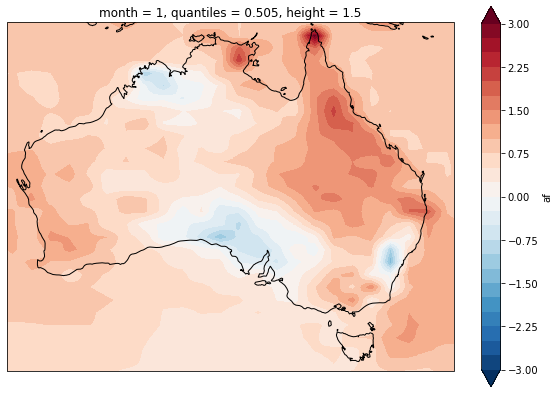

In [21]:
fig = plt.figure(figsize=[10, 7])
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
qm.ds['af'].isel({'month': 0, 'quantiles': 50}).plot(
    ax=ax,
    cmap='RdBu_r',
    transform=ccrs.PlateCarree(),
    extend='both',
    levels=np.arange(-3, 3.1, 0.25),
)
ax.coastlines()
plt.show()

In [22]:
qq_obs = qm.adjust(da_obs, extrapolation="constant", interp="linear")

In [23]:
#qq_obs = qq_obs.assign_coords({'time': qq_obs['time'].values + time_adjustment})

In [24]:
qq_obs = qq_obs.rename('tmax')
qq_obs = qq_obs.transpose('time', 'lat', 'lon')
qq_obs

,Array,Chunk
Bytes,16.66 GiB,11.15 MiB
Shape,"(7305, 691, 886)","(7305, 20, 20)"
Count,24332 Tasks,1575 Chunks
Type,float32,numpy.ndarray


In [ ]:
%%timeit
qq_obs.sel({'time': slice('1986-01-01', '1986-12-31')}).to_netcdf('/g/data/wp00/dbi599/test_qqscale.nc')

[##############################          ] | 76% Completed |  3hr 10min 56.5s